# Comparing normalizations

Trying to check differences of performance between different normalization techniques accross model versions 2.10 and 2.11

In [87]:
# seed=0

In [88]:
# MAIN_DUMP=f'../../dump_seeds/dump_{seed}'
import os,sys
from joblib import Parallel, delayed,dump,load

sys.path.append(os.path.abspath('../../src/ml'))
from load_matrix import load_df
from model_trainer import MLModel
from utils import load_models

import pandas as pd

from evaluator import Evaluator
from collector import ResultsCollector
from visualizer import DashboardVisualizer

# cache='../../results/figures/comparative_normalization_version/seed_'+str(seed)+'_normalizations/'
cache='../../results/figures/comparative_normalization_version/avg_seeds_normalizations/'
if not os.path.exists(cache):
    os.makedirs(cache)

### analysis

In [89]:
from IPython.display import display
all_results=pd.read_csv(f'../../results/score_tables/scores_avg_seeds.csv')
# all_results=pd.read_csv(f'../../results/score_tables/scores_all_seed{seed}.csv')
display(all_results)

,model,input,normalization,version,balanced_accuracy,precision,recall,f1,mcc,auroc,auprc,brier
0,pytorch_mlp,Complex_protein_embeddings,log1p,v2.10,0.500000,0.620408,0.800000,0.698851,0.000000,0.644737,0.855217,0.216289
1,pytorch_mlp,Complex_protein_embeddings,log1p,v2.11,0.500000,0.775510,1.000000,0.873563,0.000000,0.613995,0.850789,0.198840
2,pytorch_mlp,Complex_protein_embeddings,minmax,v2.10,0.500000,0.620408,0.800000,0.698851,0.000000,0.678708,0.877657,0.216016
3,pytorch_mlp,Complex_protein_embeddings,minmax,v2.11,0.500000,0.620408,0.800000,0.698851,0.000000,0.647608,0.875010,0.214031
4,pytorch_mlp,Complex_protein_embeddings,none,v2.10,0.500000,0.775510,1.000000,0.873563,0.000000,0.748565,0.909244,0.195770
...,...,...,...,...,...,...,...,...,...,...,...,...
180,xgboost,concatenated_protein_embeddings,standard,v2.10,0.511603,0.779830,0.986842,0.870946,0.047669,0.635167,0.858892,0.189191
181,xgboost,concatenated_protein_embeddings,standard,v2.11,0.517943,0.782659,0.963158,0.862753,0.046119,0.655263,0.860775,0.183196
182,xgboost,concatenated_sample_embeddings,none,v2.10,0.511603,0.779940,0.986842,0.871035,0.031607,0.539952,0.807799,0.192609
183,xgboost,concatenated_sample_embeddings,none,v2.11,0.651316,0.839586,0.902632,0.868990,0.351587,0.763636,0.912419,0.154126


In [90]:
datasets=['Complex_protein_embeddings','RGCN_protein_embeddings','concatenated_protein_embeddings']
temp_df=all_results[all_results['input'].isin(datasets)].sort_values(by=['input','model','version','normalization'])

In [91]:
df=temp_df
df['normalization'].unique()

array(['log1p', 'minmax', 'none', 'robust', 'standard'], dtype=object)

In [92]:
metric='balanced_accuracy'


#### boxplot

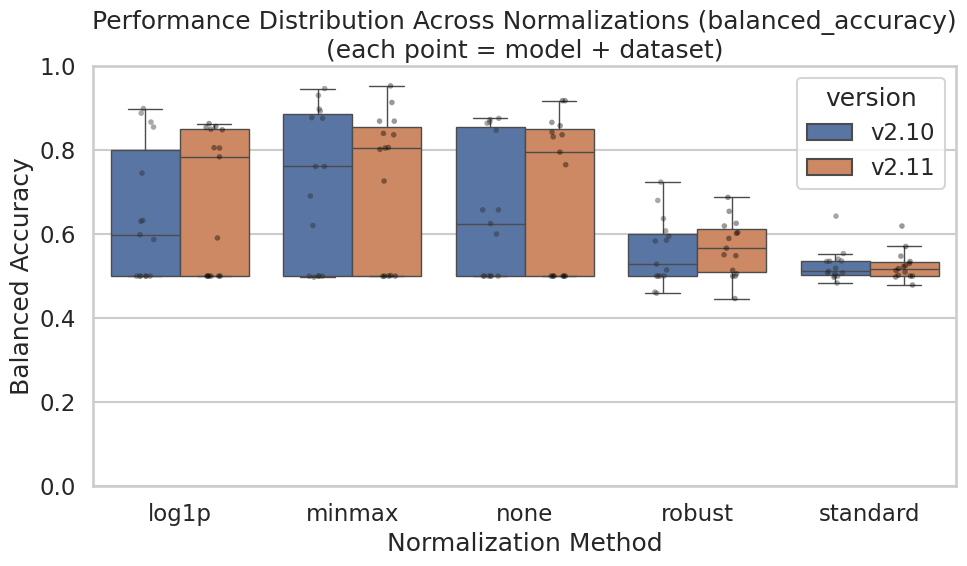

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk", palette="deep")

plt.figure(figsize=(10, 6))

sns.boxplot(
    data=df,
    x="normalization",
    y=metric,
    hue="version",
    showfliers=False
)

sns.stripplot(
    data=df,
    x="normalization",
    y=metric,
    hue="version",
    dodge=True,
    color="black",
    alpha=0.4,
    size=4,
    legend=False
)

plt.ylabel(metric.replace("_", " ").title())
plt.xlabel("Normalization Method")
plt.title(f"Performance Distribution Across Normalizations ({metric})\n(each point = model + dataset)")

plt.ylim(0, 1)
plt.tight_layout()

plt.savefig(os.path.join(cache, f'boxplot_comparative_normalization_version_{metric}.png'))
plt.show()


#### bar plots

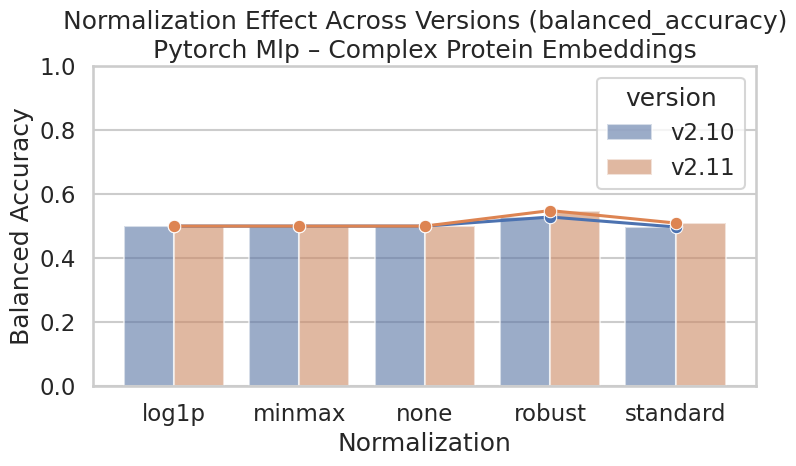

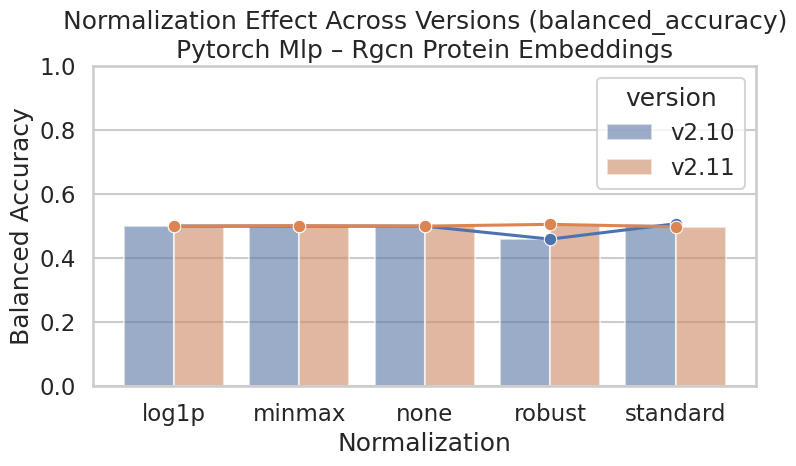

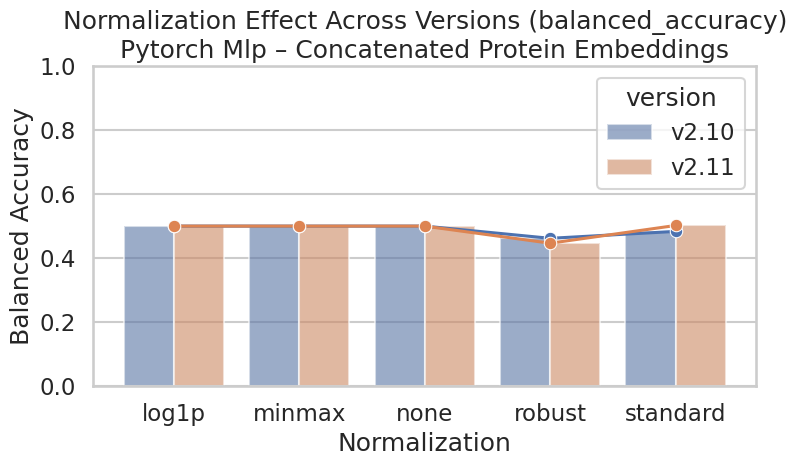

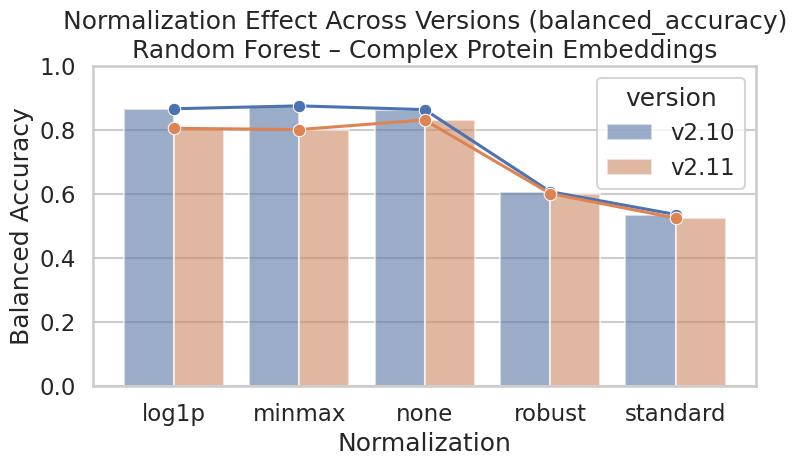

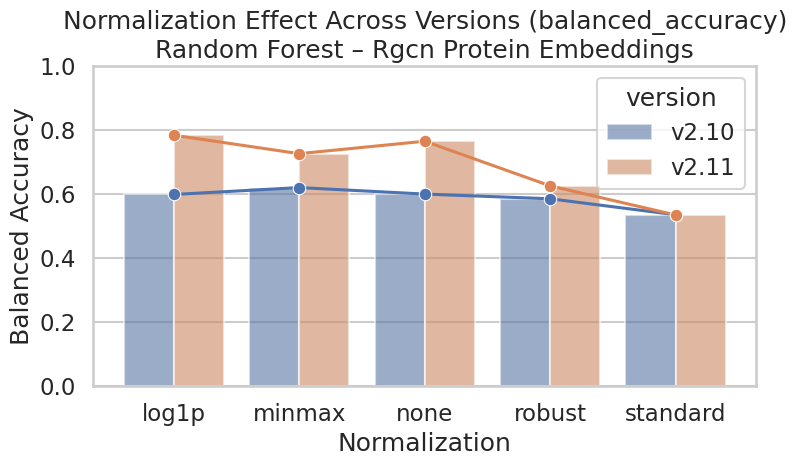

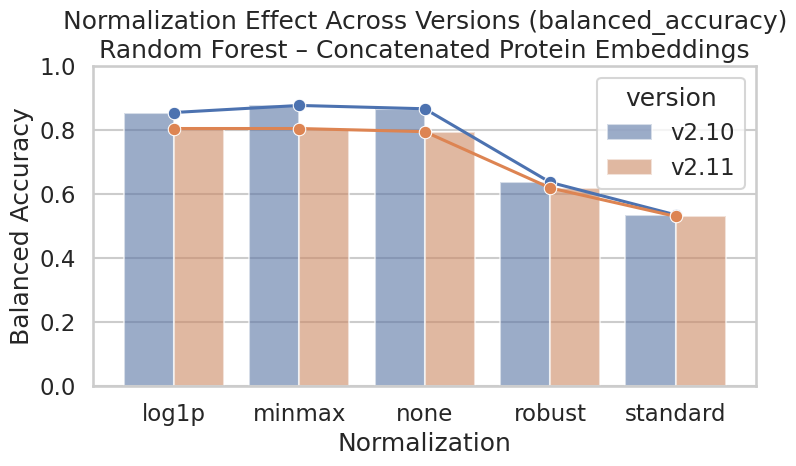

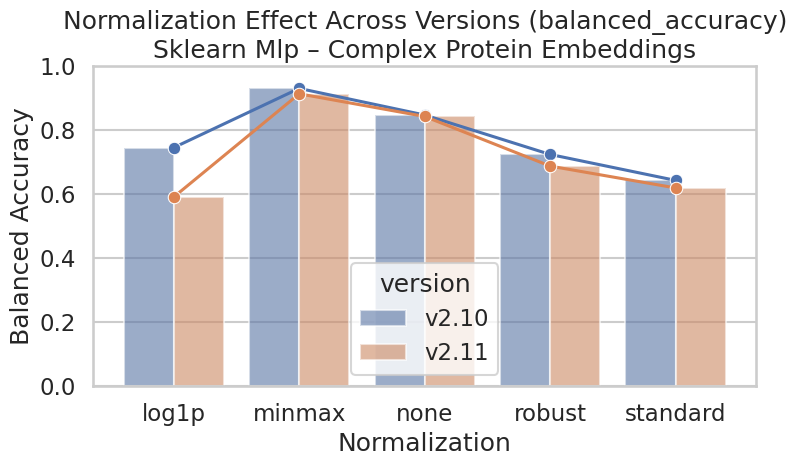

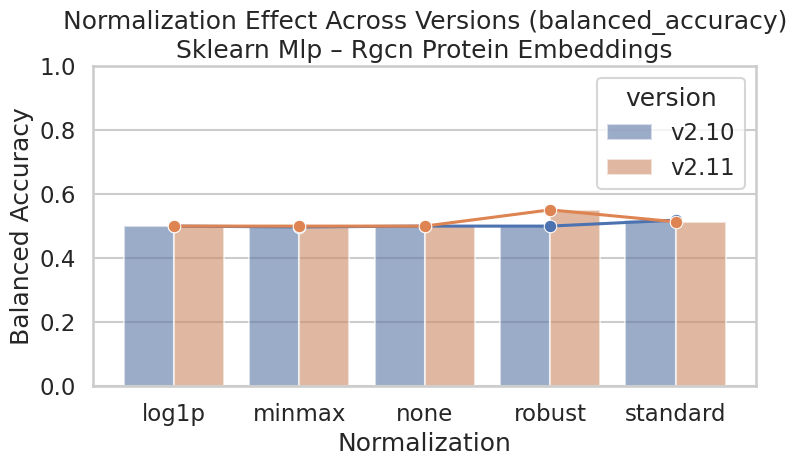

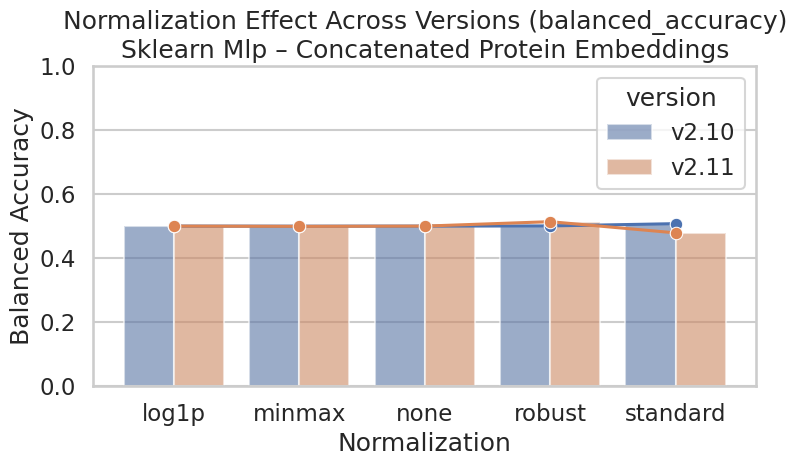

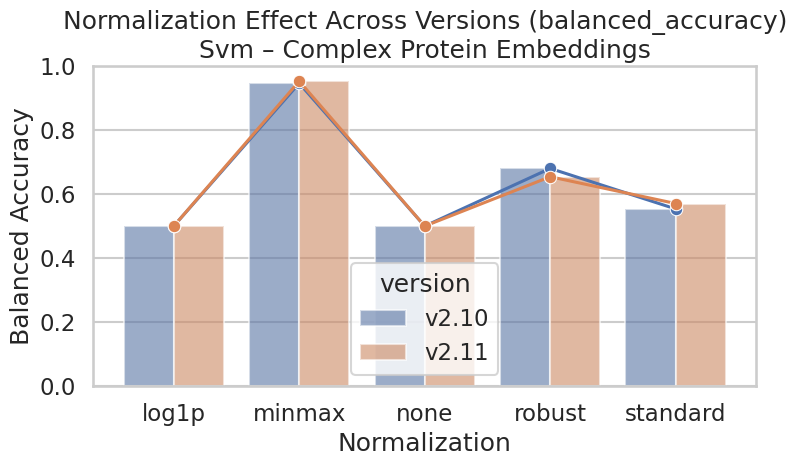

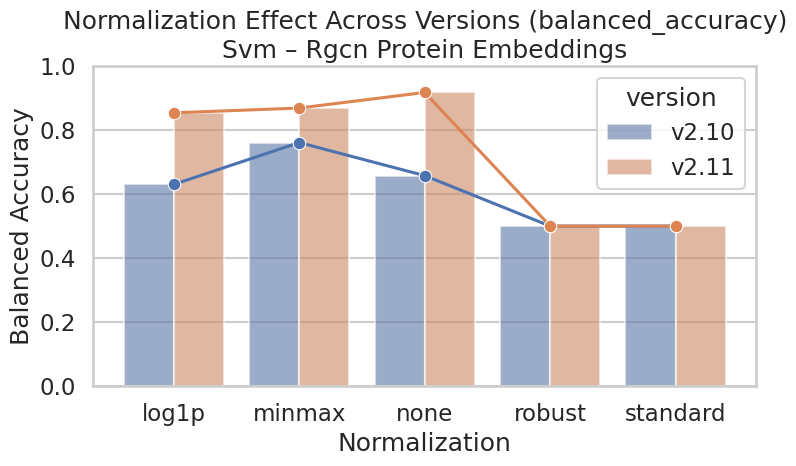

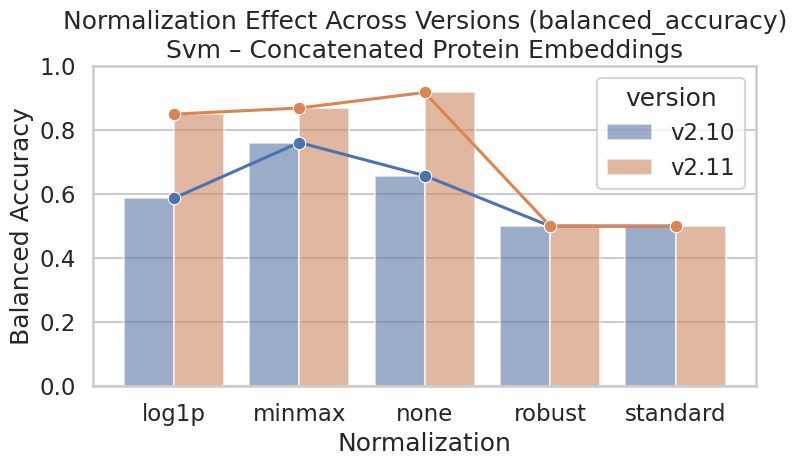

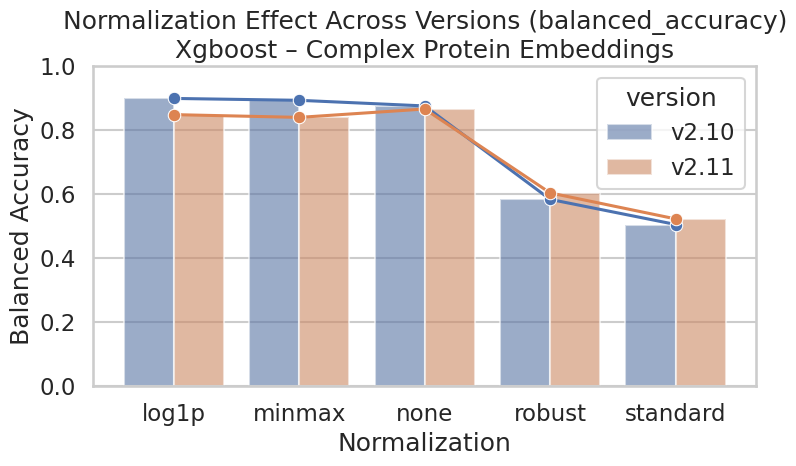

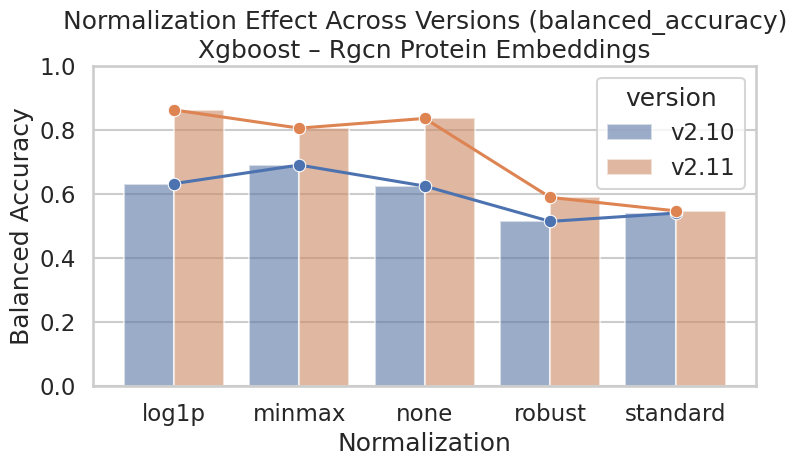

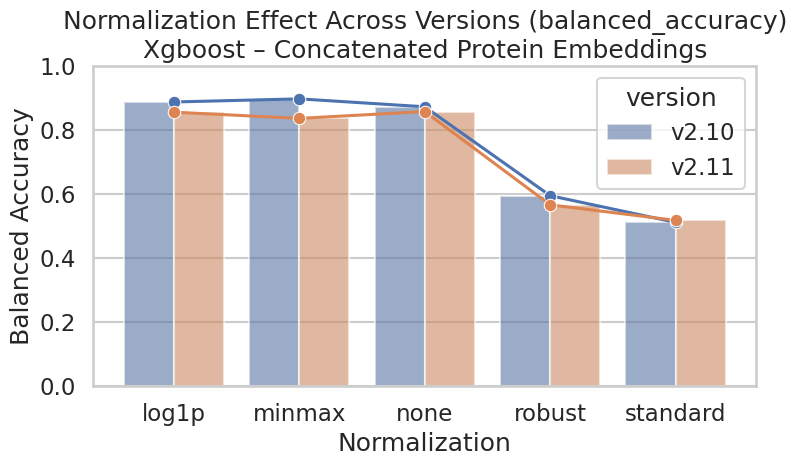

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns


for model in df['model'].unique():
    for dataset in df['input'].unique():
        subset = df[(df["model"] == model) & (df["input"] == dataset)]
        
        plt.figure(figsize=(8,5))
        
        sns.barplot(
            data=subset,
            x="normalization",
            y=metric,
            hue="version",
            alpha=0.6, 
            ci=None      # remove confidence interval for cleaner look
        )
        
        sns.lineplot(
            data=subset,
            x="normalization",
            y=metric,
            hue="version",
            marker="o",
            linewidth=2.2,
            legend=False   # avoid duplicate legend
        )

        plt.ylabel(metric.replace("_", " ").title())
        plt.xlabel("Normalization")
        plt.title(f"Normalization Effect Across Versions ({metric})\n{model.replace('_',' ').title()} – {dataset.replace('_',' ').title()}")
        plt.ylim(0, 1)

        plt.tight_layout()

        plt.savefig(os.path.join(cache, f'barplot_{model}_{dataset}_{metric}.png'))
        plt.show()